# ML4DS - Model Selection

## Introduction

You will explore the various options for model selection on a *clustering* task.

In the first section, you will use synthetic data, where we know the true number of clusters. In the second (which will make up the assessed task), you will compare multiple methods for model selection on a real dataset.

## Import Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import silhouette_score
from sklearn import mixture
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import itertools
from scipy import linalg
import matplotlib as mpl

# Part 1: synthetic data

### Generate some data

Make data from a mixture of gaussians using sklearn `make_blobs` method. Try experimenting with:
- The number of centers
- the `cluster_std`
- The total number of samples

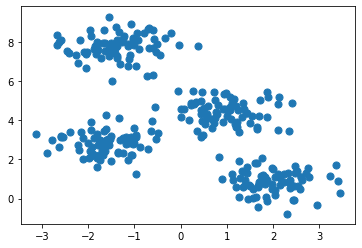

In [4]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.6, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

# Clustering - K-Means Example

Using the `KMeans` model, try and optimise, plot a graph of $K$ versus the `inertia_` value of the clustering. The `inertia_` value is the quantity that is minimised when K-means is training: the total sum of squared errors between the observations and the cluster centre to which they are assigned.

__Question__: what do you notice about this curve? Do you think you could use it to choose the correct number of clusters? See e.g. https://en.wikipedia.org/wiki/Elbow_method_(clustering). What happens when you vary the parameters used to generate the data (above)

__Question__ Choose K using the Elbow Method

__Question__: using the value of $K$ you have chosen, fit the clustering and then use the following code to plot the data coloured by cluster assignment. You can get the cluster assignment using the following code:
`y_kmeans = kmeans.predict(X)`

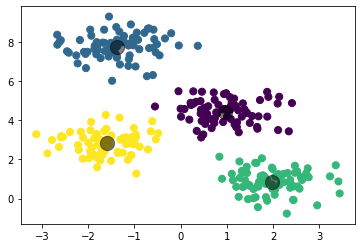

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### Silhouette Score for K for K-Means

The silhouette score (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) is a method for optimising $K$ in a clustering setting. It computes how similar objects are to other objects within their cluster compared to how similar they are to points in neighbouring clusters.

__Question__: make a plot of Silhouette scores for the example data above. Vary the data generation parameters. Does the optimal $K$ from Silhouette agree with that from inspecting the inertia?

## BIC for K-means

Although K-means is not optimised by maximising the likelihood, you can compute a quanitity that is interpretable as BIC. To do this, compute:

$KD\ln(N) - E$

where $E$ is the negative of the `inertia_` property of K-means, and $D$ is the dimension of the data (in our case, 2).

__Question:__ for the data above, plot BIC for K-means as a function of $K$ for $K$ varying from 1 to 30. Does it agree with the previous answers?


# Mixture Models

Statistical mixture models are somewhat related to K-means but place the clustering problem within a statistical framework.

We will use Gaussian mixtures: models in which data from each cluster is assumed to come from a different Gaussian. With mixture models we have two model selection challenges: choosing $K$ and choosing the form of the Gaussian covariance matrices:

- spherical: the covariance matrices are of the form $\sigma^2\mathbf{I}$ (where $\mathbf{I}$ is an identity), i.e. the variance is the same in all dimensions and there is no correlation structure
- diagonal: there is no correlation structure, but the variance can be different in each dimension
- tied: all Gaussians share the same covariance matrix
- full: each Gaussian can have a different covariance matrix that can have full correlation structure

See https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html

To create a Gaussian mixture object using sklearn with (say) a tied covariance structure, use:

```{python}
from sklearn import mixture
gmm = mixture.Gaussian(n_components = K,covariance_type='cv_type')
```

__Note__
- the `mixture.Gaussian` object has methods to compute BIC and AIC (`gmm.bic(X)` etc)
- you can also perform cross validation with a mixture, but computing the likelihood on held-out observations. The likelihood is the standard mixture likelihood:

$L = \prod_n \sum_k \pi_k p(x_n|k)$

where the product is over the held-out data, the sum is over the clusters, $\pi_k$ is the prior weight of cluster k (`gmm.weights_`) and $p(x_n|k)$ is the Gaussian likelihood of the nth observation in the kth cluster.

## Additional imports...

In [57]:
import numpy as np
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from sklearn import mixture

### Load a real data set

In [53]:
digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

### Useful code to plot a single digit

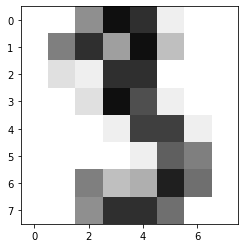

In [55]:
# method to plot a single digit
def plot_digit(digit_data):
    im = plt.imshow(digit_data.reshape(8,8), cmap='binary')
    im.set_clim(0, 16)

# example - plot the third one in the dataset    
plot_digit(digits.data[3])

### Project the data into 2D

In [56]:
reduced_data = PCA(n_components=2).fit_transform(data)

([], <a list of 0 Text yticklabel objects>)

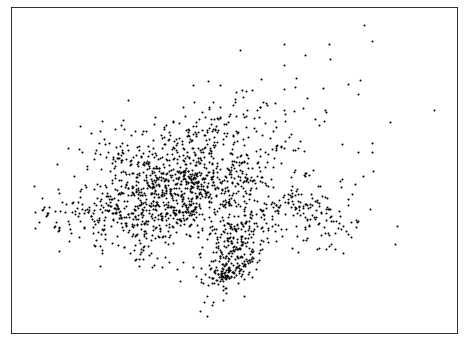

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

## The task

Explore different model selection strategies to determine the number of clusters required for a Gaussian mixture clustering of this data (in the 2D PCA space) **and** the correct choice of covariance matrix structure (from the options listed above).

You should try multiple methods (BIC, AIC, Silhouette, and cross-validation)

Explore the clusterings suggested by each method, and look to see which digits are being grouped or split (if the optimal number is not 10 (digits 0-9).

The following method might be useful to plot the result of the clustering(s) and nice covariance ellipses

In [61]:
from matplotlib.patches import Ellipse
colors = ['navy', 'turquoise', 'darkorange','red'] # will need to add other colours here if more clusters
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

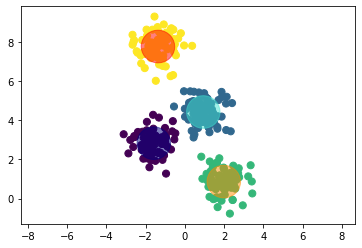

In [62]:
# Example usage
plt.scatter(X[:, 0], X[:, 1], c=clf.predict(X), s=50, cmap='viridis')
make_ellipses(clf, plt.gca())